In [6]:
import sys
sys.path.insert(0,'/Users/a_piao/PycharmProjects/BankMarketing')

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, KFold
from models.WideDeep import WDL
import feature_engineering
from utils import inputs,metric

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

Using TensorFlow backend.


# Metric and plot

In [2]:
from  sklearn import metrics

model = []
accuracy_score = []
recall_score = []
precision_score = []
f1_score = []
ROC_AUC_Score = []
FPR = []
TPR = []

def cal_roc_curve(target, oof, name, threshold=0.5):
    clf_fpr, clf_tpr, thresholds = metrics.roc_curve(target, oof)
    precision, recall, thresholds = metrics.precision_recall_curve(target, oof)
    clf_roc_auc = metrics.auc(clf_fpr, clf_tpr)  # 计算auc的值
    plot_pr(clf_roc_auc, precision, recall, name)


    y_pred_clf = np.zeros(len(oof), dtype=int)
    for i in range(len(oof)):
        if oof[i] >= threshold:
            y_pred_clf[i] = 1
        else:
            y_pred_clf[i] = 0

    print('\n>>>在测试集上的表现：', metrics.accuracy_score(target, y_pred_clf))
    print('\n>>>混淆矩阵\n', metrics.confusion_matrix(target, y_pred_clf))
    print('\n>>>分类评价函数\n', metrics.classification_report(target, y_pred_clf))

    model.append(name)
    FPR.append(clf_fpr)
    TPR.append(clf_tpr)
    precision = metrics.precision_score(target, y_pred_clf, average='binary')
    accuracy_score.append(metrics.accuracy_score(target, y_pred_clf))
    recall_score.append(metrics.recall_score(target, y_pred_clf, average='binary'))
    precision_score.append(metrics.precision_score(target, y_pred_clf, average='binary'))
    f1_score.append(metrics.f1_score(target, y_pred_clf, average='binary'))
    ROC_AUC_Score.append(metrics.roc_auc_score(target, oof))


def plot_roc_curve():
    lw = 2
    plt.figure(figsize=(10, 10))
    for i in range(len(model)):
        model_name = model[i]
        fpr, tpr = FPR[i], TPR[i]
        auc = ROC_AUC_Score[i]
        col = metric.randomcolor()
        plt.plot(fpr, tpr, color=col, lw=lw, label='%s(area = %0.3f)' % (model_name, auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of classification models')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_pr(auc_score, precision, recall, label=None):
    plt.figure(num=None, figsize=(8, 6))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    plt.fill_between(recall, precision, alpha=0.2)
    plt.grid(True, linestyle='-', color='0.75')
    plt.plot(recall, precision, lw=1)
    plt.show()

# Machine Learning Models

### LogisticRegression

In [3]:
from sklearn.linear_model import LogisticRegression

def train_LR():
    X, y = feature_engineering.get_train_data(use_over_sampler=True)
    data = pd.DataFrame(y)

    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        model = LogisticRegression(solver='lbfgs', penalty='l2', class_weight='balanced', max_iter=300, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % model.__class__.__name__)
    cal_roc_curve(data['y'], data['y_pred'], model.__class__.__name__)

    return data['y_pred']

original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
Fold : 0
AUC score at 0 floder: 0.776329
Fold : 1
AUC score at 1 floder: 0.644461
Fold : 2
AUC score at 2 floder: 0.534611
Fold : 3
AUC score at 3 floder: 0.651974
Fold : 4
AUC score at 4 floder: 0.640043
5-floder total mean_score: 0.64948338993736
5-floder oof auc score: 0.6279441119578976
----train LogisticRegression finish!----


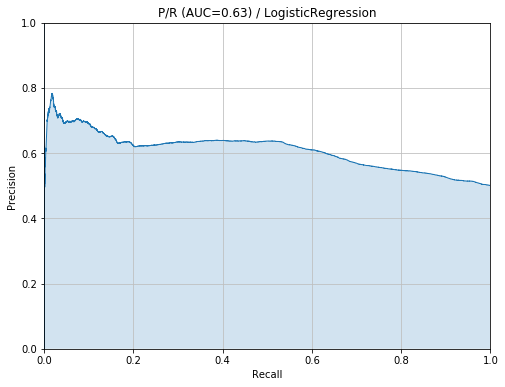


>>>在测试集上的表现： 0.6081312824842361

>>>混淆矩阵
 [[23360 14543]
 [15163 22740]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.61      0.62      0.61     37903
           1       0.61      0.60      0.60     37903

    accuracy                           0.61     75806
   macro avg       0.61      0.61      0.61     75806
weighted avg       0.61      0.61      0.61     75806



In [4]:
lr_oof = train_LR()

### KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn():
    X, y = feature_engineering.get_train_data(use_over_sampler=True)
    data = pd.DataFrame(y)
    # kFold cv
    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        model = KNeighborsClassifier(n_neighbors=5,weights='uniform', algorithm='auto', leaf_size=30,
                                     p=2, metric='minkowski')
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % model.__class__.__name__)
    cal_roc_curve(data['y'], data['y_pred'], model.__class__.__name__)

    return data['y_pred']


original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
Fold : 0
AUC score at 0 floder: 0.870301
Fold : 1
AUC score at 1 floder: 0.859533
Fold : 2
AUC score at 2 floder: 0.820272
Fold : 3
AUC score at 3 floder: 0.850282
Fold : 4
AUC score at 4 floder: 0.809631
5-floder total mean_score: 0.842003718665054
5-floder oof auc score: 0.8412791866816827
----train KNeighborsClassifier finish!----


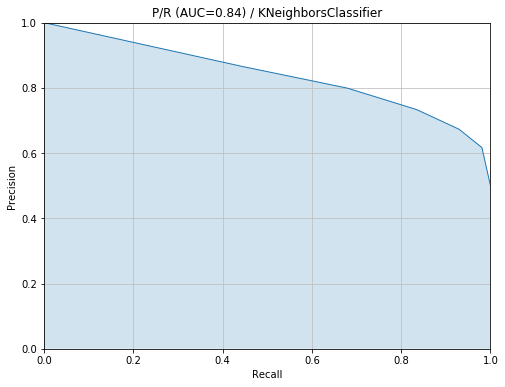


>>>在测试集上的表现： 0.7656254122364984

>>>混淆矩阵
 [[26403 11500]
 [ 6267 31636]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.81      0.70      0.75     37903
           1       0.73      0.83      0.78     37903

    accuracy                           0.77     75806
   macro avg       0.77      0.77      0.76     75806
weighted avg       0.77      0.77      0.76     75806



In [6]:
knn_oof = train_knn()

# Tree Models

### Random Forest

In [7]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

def train_tree(model):
    X, y = feature_engineering.get_train_data(use_over_sampler=True)
    data = pd.DataFrame(y)
    # kFold cv
    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        # model = RandomForestClassifier()
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % model.__class__.__name__)
    cal_roc_curve(data['y'], data['y_pred'], model.__class__.__name__)

    return data['y_pred']


original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
Fold : 0
AUC score at 0 floder: 0.943527
Fold : 1
AUC score at 1 floder: 0.989502
Fold : 2
AUC score at 2 floder: 0.985781
Fold : 3
AUC score at 3 floder: 0.983815
Fold : 4
AUC score at 4 floder: 0.949505
5-floder total mean_score: 0.9704262465638575
5-floder oof auc score: 0.9498676635114687
----train RandomForestClassifier finish!----


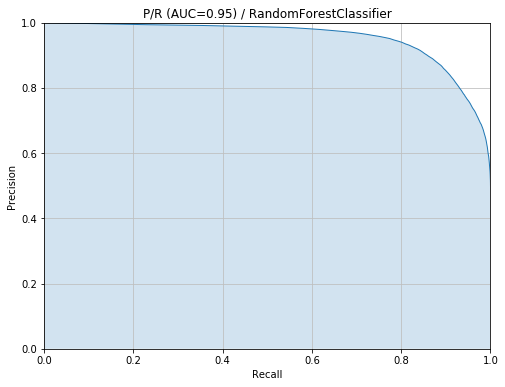


>>>在测试集上的表现： 0.8509352821676385

>>>混淆矩阵
 [[29303  8600]
 [ 2700 35203]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.92      0.77      0.84     37903
           1       0.80      0.93      0.86     37903

    accuracy                           0.85     75806
   macro avg       0.86      0.85      0.85     75806
weighted avg       0.86      0.85      0.85     75806



In [8]:
rf_oof = train_tree(RandomForestClassifier(n_estimators=100,
             criterion="gini",
             max_depth=None,
             min_samples_split=2,
             min_samples_leaf=1,
             min_weight_fraction_leaf=0.,
             max_features="auto",
             max_leaf_nodes=None,
             min_impurity_decrease=0.,
             min_impurity_split=None,
             bootstrap=True))

### GBDT

original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
Fold : 0
AUC score at 0 floder: 0.926596
Fold : 1
AUC score at 1 floder: 0.965417
Fold : 2
AUC score at 2 floder: 0.980302
Fold : 3
AUC score at 3 floder: 0.952925
Fold : 4
AUC score at 4 floder: 0.923949
5-floder total mean_score: 0.9498377347784155
5-floder oof auc score: 0.9233992315593391
----train GradientBoostingClassifier finish!----


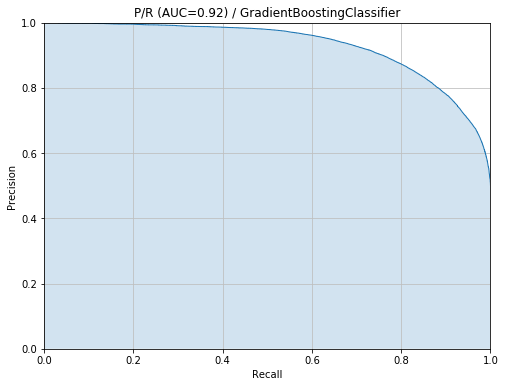


>>>在测试集上的表现： 0.8262802416695249

>>>混淆矩阵
 [[28775  9128]
 [ 4041 33862]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.88      0.76      0.81     37903
           1       0.79      0.89      0.84     37903

    accuracy                           0.83     75806
   macro avg       0.83      0.83      0.83     75806
weighted avg       0.83      0.83      0.83     75806



In [9]:
gbdt_oof = train_tree(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,
                 subsample=1.0, criterion='friedman_mse', min_samples_split=2,
                 min_samples_leaf=1, min_weight_fraction_leaf=0.,
                 max_depth=3, min_impurity_decrease=0.))

### ExtraTrees

original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
Fold : 0
AUC score at 0 floder: 0.912944
Fold : 1
AUC score at 1 floder: 0.989485
Fold : 2
AUC score at 2 floder: 0.982917
Fold : 3
AUC score at 3 floder: 0.976874
Fold : 4
AUC score at 4 floder: 0.918087
5-floder total mean_score: 0.9560614787533522
5-floder oof auc score: 0.9335978059582882
----train ExtraTreesClassifier finish!----


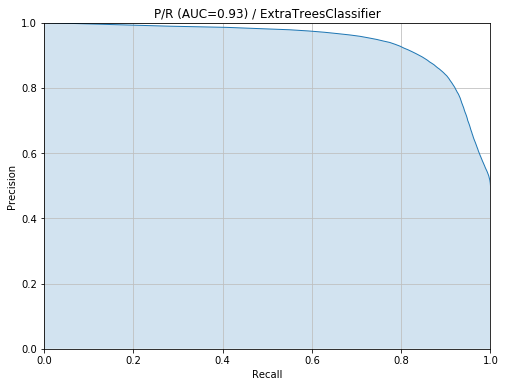


>>>在测试集上的表现： 0.8186687069625096

>>>混淆矩阵
 [[26636 11267]
 [ 2479 35424]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.91      0.70      0.79     37903
           1       0.76      0.93      0.84     37903

    accuracy                           0.82     75806
   macro avg       0.84      0.82      0.82     75806
weighted avg       0.84      0.82      0.82     75806



In [10]:
et_oof = train_tree(ExtraTreesClassifier(n_estimators=100,
                 criterion="gini",
                 max_depth=7,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features="auto"))

### Xgboost

In [11]:
from xgboost.sklearn import XGBClassifier

def train_xgb(plot=False):
    X, y = feature_engineering.get_train_data(use_over_sampler=True)
    data = pd.DataFrame(y)
    # kFold cv
    models = []
    scores = []
    checkpoint_predictions = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        params = {
            'learning_rate': .05,
            'n_estimators': 2000,
            'max_depth': 8,
            'min_child_weight': 4,
            'gamma': .2,
            'subsample': .8,
            'colsample_bytree': .8,

            'n_jobs': -1,
            'random_state': 0
        }
        model = XGBClassifier().set_params(**params)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50,
                  verbose=False)

        ## plot feature importance
        if plot and i == 0:
            fscores = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
            fscores.plot(kind='bar', title='Feature Importance %d' % i, figsize=(20, 10))
            plt.ylabel('Feature Importance Score')
            plt.show()

        y_pred = model.predict_proba(X_val, ntree_limit=model.best_ntree_limit)[:, 1]
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % model.__class__.__name__)
    cal_roc_curve(data['y'], data['y_pred'], model.__class__.__name__)

    return data['y_pred']


original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
Fold : 0


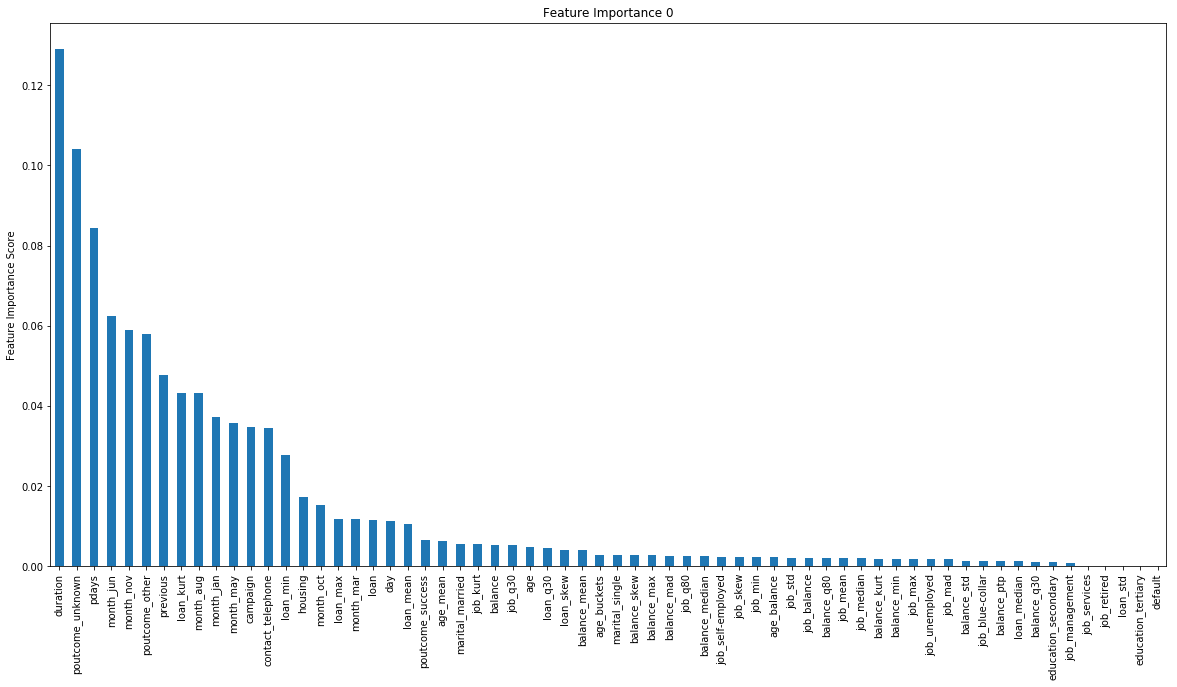

AUC score at 0 floder: 0.907624
Fold : 1
AUC score at 1 floder: 0.996487
Fold : 2
AUC score at 2 floder: 0.965352
Fold : 3
AUC score at 3 floder: 0.991516
Fold : 4
AUC score at 4 floder: 0.882030
5-floder total mean_score: 0.9486017842874077
5-floder oof auc score: 0.9005530671100601
----train XGBClassifier finish!----


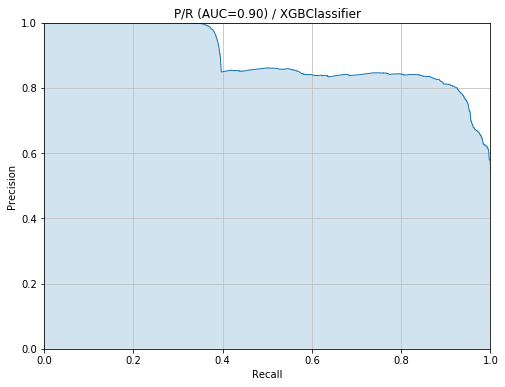


>>>在测试集上的表现： 0.8469646202147587

>>>混淆矩阵
 [[29243  8660]
 [ 2941 34962]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.91      0.77      0.83     37903
           1       0.80      0.92      0.86     37903

    accuracy                           0.85     75806
   macro avg       0.86      0.85      0.85     75806
weighted avg       0.86      0.85      0.85     75806



In [12]:
xgb_oof = train_xgb(plot=True)

### LightGBM

In [13]:
from lightgbm import LGBMClassifier

def train_lgbm(plot=False):
    X, y = feature_engineering.get_train_data(use_over_sampler=True)
    data = pd.DataFrame(y)
    # kFold cv
    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        params = {
            'learning_rate': .05,
            'n_estimators': 2000,
            'num_leaves': 50,
            'min_split_gain': 0,
            'min_child_weight': 1e-3,
            'min_child_samples': 21,
            'subsample': .8,
            'colsample_bytree': .8,

            'n_jobs': -1,
            'random_state': 0
        }
        model = LGBMClassifier().set_params(**params)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50,
                  verbose=False)

        ## plot feature importance
        if plot and i == 0:
            fscores = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
            fscores.plot(kind='bar', title='Feature Importance %d' % i, figsize=(20, 10))
            plt.ylabel('Feature Importance Score')
            plt.show()

        y_pred = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:,1]
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % model.__class__.__name__)
    cal_roc_curve(data['y'], data['y_pred'], model.__class__.__name__)

    return data['y_pred']

original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
Fold : 0


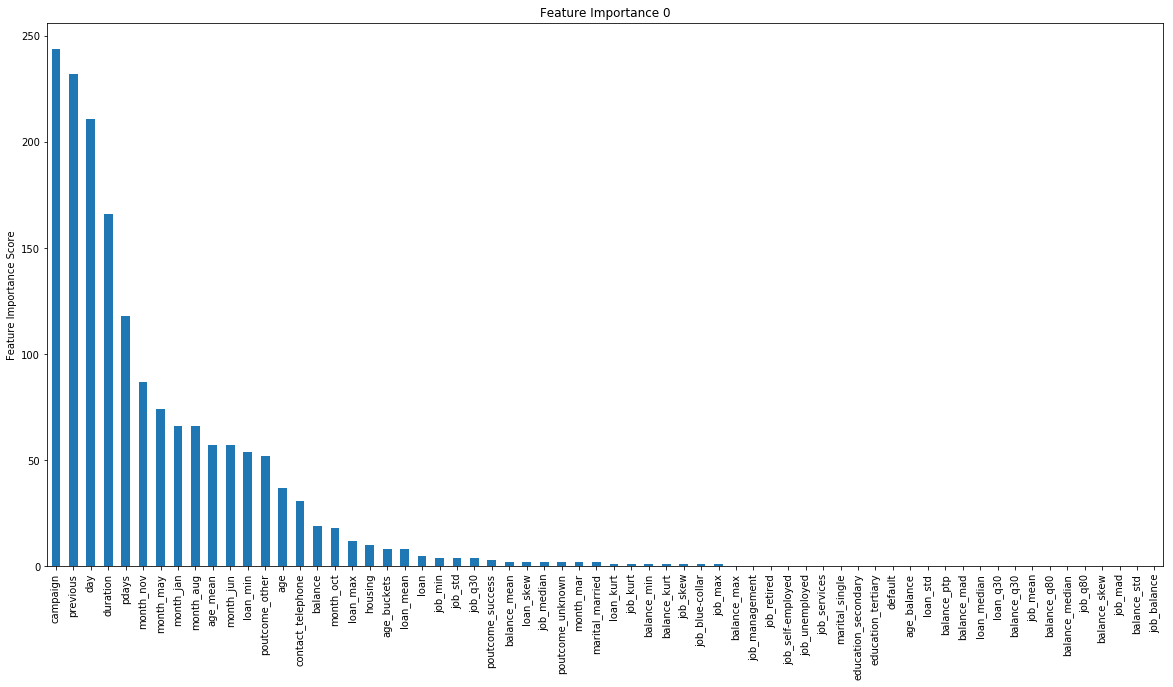

AUC score at 0 floder: 0.902812
Fold : 1
AUC score at 1 floder: 0.993895
Fold : 2
AUC score at 2 floder: 0.990467
Fold : 3
AUC score at 3 floder: 0.994505
Fold : 4
AUC score at 4 floder: 0.952715
5-floder total mean_score: 0.9668789101713751
5-floder oof auc score: 0.9505115239554506
----train LGBMClassifier finish!----


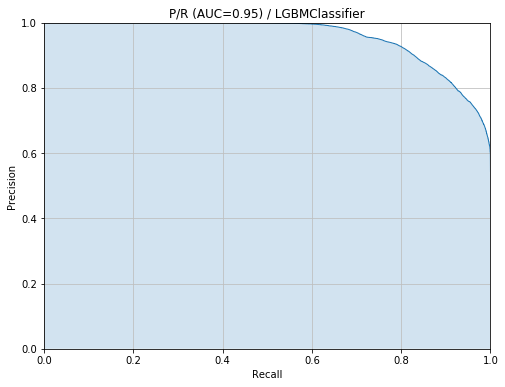


>>>在测试集上的表现： 0.8494182518534154

>>>混淆矩阵
 [[29632  8271]
 [ 3144 34759]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.90      0.78      0.84     37903
           1       0.81      0.92      0.86     37903

    accuracy                           0.85     75806
   macro avg       0.86      0.85      0.85     75806
weighted avg       0.86      0.85      0.85     75806



In [14]:
lgbm_oof = train_lgbm(plot=True)

### Catboost

In [15]:
from catboost import CatBoostClassifier

def train_cat(plot=False):
    X, y = feature_engineering.get_train_data(use_over_sampler=True)
    data = pd.DataFrame(y)

    # kFold cv
    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        params = {
            'learning_rate': .05,
            'n_estimators': 2000,
            'max_depth': 8,
            'max_bin': 127,
            'reg_lambda': 2,
            'subsample': .7,

            'one_hot_max_size': 2,
            'bootstrap_type': 'Bernoulli',
            'leaf_estimation_method': 'Newton',

            'random_state': 0
        }
        model = CatBoostClassifier().set_params(**params)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50,
                  verbose=False)

        ## plot feature importance
        if plot and i == 0:
            fscores = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
            fscores.plot(kind='bar', title='Feature Importance %d' % i, figsize=(20, 10))
            plt.ylabel('Feature Importance Score')
            plt.show()

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % model.__class__.__name__)
    cal_roc_curve(data['y'], data['y_pred'], model.__class__.__name__)

    return data['y_pred']

original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
Fold : 0


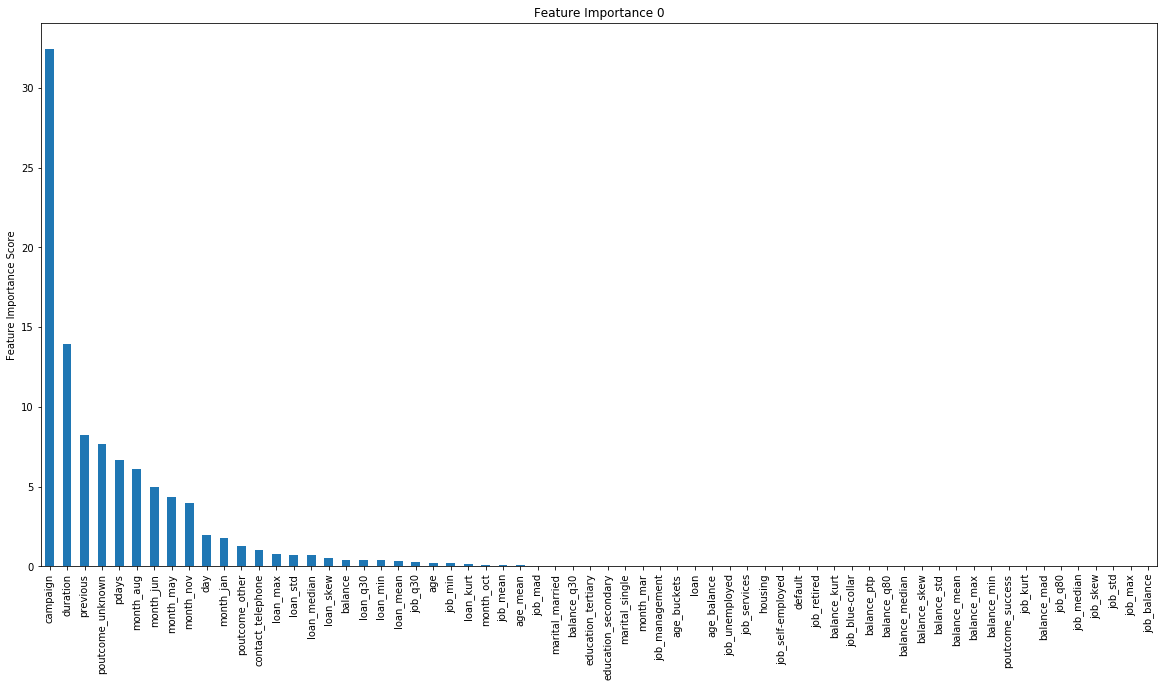

AUC score at 0 floder: 0.924825
Fold : 1
AUC score at 1 floder: 0.990292
Fold : 2
AUC score at 2 floder: 0.983668
Fold : 3
AUC score at 3 floder: 0.970775
Fold : 4
AUC score at 4 floder: 0.855342
5-floder total mean_score: 0.9449804134846426
5-floder oof auc score: 0.9306100513772714
----train CatBoostClassifier finish!----


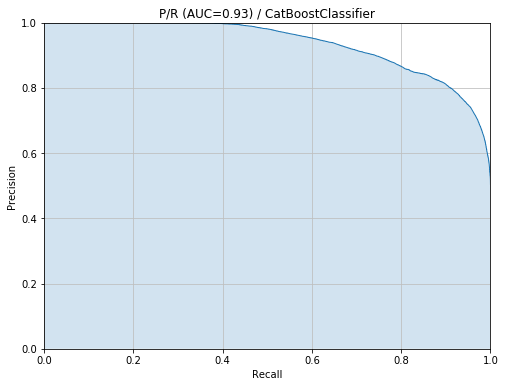


>>>在测试集上的表现： 0.8388913806295016

>>>混淆矩阵
 [[28848  9055]
 [ 3158 34745]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.90      0.76      0.83     37903
           1       0.79      0.92      0.85     37903

    accuracy                           0.84     75806
   macro avg       0.85      0.84      0.84     75806
weighted avg       0.85      0.84      0.84     75806



In [16]:
cat_oof = train_cat(plot=True)

# NN models

### FNN

In [17]:
from models.FNN import FNN

def train_FNN():
    X, y, sparse_list, dense_list = feature_engineering.get_NN_data(use_over_sampler=True)

    data = pd.DataFrame(y)
    dnn_feature_columns = linear_feature_columns = sparse_list + dense_list
    feature_names = inputs.get_feature_names(linear_feature_columns + dnn_feature_columns)

    # kFold cv
    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        X_train = {name: X_train[name] for name in feature_names}
        X_val = {name: X_val[name] for name in feature_names}

        model = FNN(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 64), task='binary',
                    dnn_dropout=0.5)

        best_param_path = './workspace/FNN/best_param_FNN.py_%d.h5' % i

        if os.path.exists(best_param_path):
            model.load_weights(best_param_path)
        else:
            model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
            es = EarlyStopping(monitor='val_binary_crossentropy', mode='min', patience=15)
            mc = ModelCheckpoint(best_param_path, monitor='val_binary_crossentropy', mode='min', save_best_only=True,
                                 verbose=False, save_weights_only=True)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=1024, epochs=1000, verbose=2,
                      callbacks=[es, mc])
            model.load_weights(best_param_path)

        y_pred = model.predict(X_val, batch_size=64).flatten()
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % 'FNN')
    cal_roc_curve(data['y'], data['y_pred'], 'FNN')
    
    return data['y_pred']

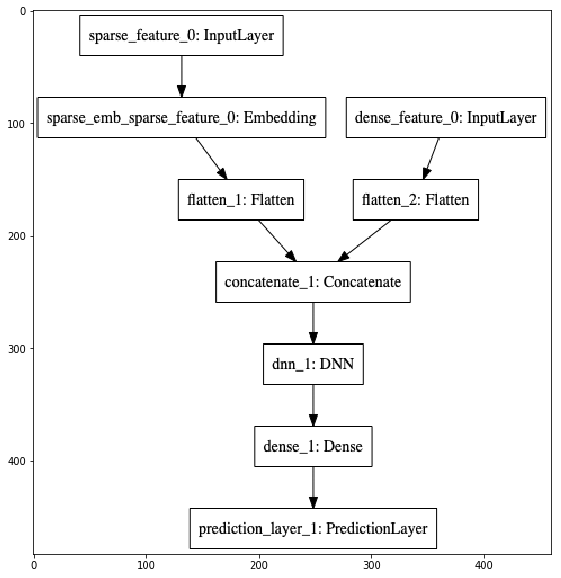

In [8]:
# FNN.FNN_test(2, 4) 读取生成的网络结构图片
import matplotlib.image as mpimg

plt.figure(figsize=(10, 10))
I = mpimg.imread('models/FNN_2019-12-21 19:16:29.png')
plt.imshow(I)
plt.show()

remain unknown feature:  ['contact', 'poutcome']
after feature engineering: (42808, 54)
original data:  (42808, 53) (42808,)
after over_sampler:  (75806, 53) (75806,)
Fold : 0
AUC score at 0 floder: 0.969701
Fold : 1
AUC score at 1 floder: 0.969255
Fold : 2
AUC score at 2 floder: 0.969710
Fold : 3
AUC score at 3 floder: 0.969778
Fold : 4
AUC score at 4 floder: 0.969925
5-floder total mean_score: 0.9696736571282409
5-floder oof auc score: 0.9696356890564586
----train FNN finish!----


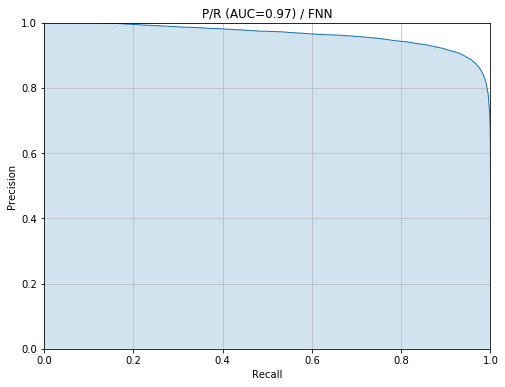


>>>在测试集上的表现： 0.9172097195472654

>>>混淆矩阵
 [[33599  4304]
 [ 1972 35931]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.94      0.89      0.91     37903
           1       0.89      0.95      0.92     37903

    accuracy                           0.92     75806
   macro avg       0.92      0.92      0.92     75806
weighted avg       0.92      0.92      0.92     75806



In [18]:
fnn_oof = train_FNN()

### PNN

In [19]:
from models.PNN import PNN

def train_PNN():
    X, y, sparse_list, dense_list = feature_engineering.get_NN_data(use_over_sampler=True)

    data = pd.DataFrame(y)
    dnn_feature_columns = linear_feature_columns = sparse_list + dense_list
    feature_names = inputs.get_feature_names(linear_feature_columns + dnn_feature_columns)

    # kFold cv
    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        X_train = {name: X_train[name] for name in feature_names}
        X_val = {name: X_val[name] for name in feature_names}

        model = PNN(dnn_feature_columns, dnn_hidden_units=(128, 64), task='binary', dnn_dropout=0.5)

        best_param_path = './workspace/PNN/best_param_PNN.py_%d.h5' % i

        if os.path.exists(best_param_path):
            model.load_weights(best_param_path)
        else:
            model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
            es = EarlyStopping(monitor='val_binary_crossentropy', mode='min', patience=15)
            mc = ModelCheckpoint(best_param_path, monitor='val_binary_crossentropy', mode='min', save_best_only=True,
                                 verbose=False, save_weights_only=True)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=1024, epochs=1000, verbose=2,
                      callbacks=[es, mc])
            model.load_weights(best_param_path)

        y_pred = model.predict(X_val, batch_size=64).flatten()
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % 'PNN')
    cal_roc_curve(data['y'], data['y_pred'], 'PNN')
    
    return data['y_pred']

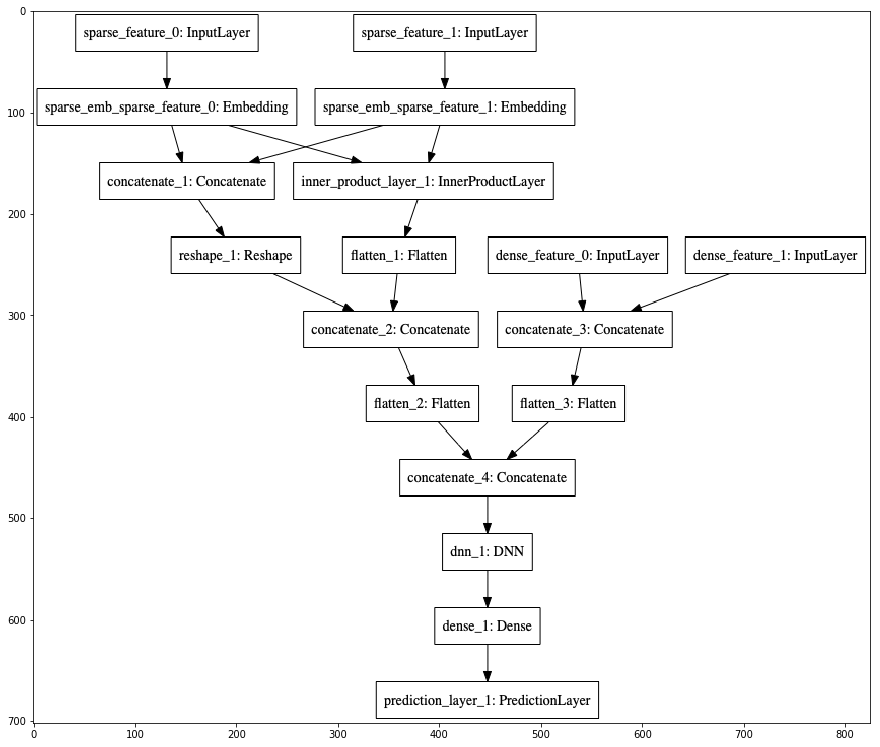

In [11]:
# PNN.PNN_test(2, 4) 读取生成的网络结构图片
plt.figure(figsize=(15, 15))
I = mpimg.imread('models/PNN_2019-12-21 19:07:18.png')
plt.imshow(I)
plt.show()

remain unknown feature:  ['contact', 'poutcome']
after feature engineering: (42808, 54)
original data:  (42808, 53) (42808,)
after over_sampler:  (75806, 53) (75806,)
Fold : 0
Instructions for updating:
keep_dims is deprecated, use keepdims instead
AUC score at 0 floder: 0.970994
Fold : 1
AUC score at 1 floder: 0.970039
Fold : 2
AUC score at 2 floder: 0.969527
Fold : 3
AUC score at 3 floder: 0.970133
Fold : 4
AUC score at 4 floder: 0.971343
5-floder total mean_score: 0.9704069449991165
5-floder oof auc score: 0.9703710771184575
----train PNN finish!----


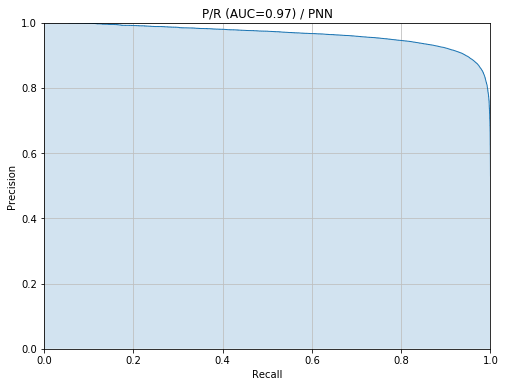


>>>在测试集上的表现： 0.9195842017782233

>>>混淆矩阵
 [[33692  4211]
 [ 1885 36018]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.95      0.89      0.92     37903
           1       0.90      0.95      0.92     37903

    accuracy                           0.92     75806
   macro avg       0.92      0.92      0.92     75806
weighted avg       0.92      0.92      0.92     75806



In [20]:
pnn_oof = train_PNN()

### DeepFM

In [21]:
from models.DeepFM import DeepFM

def train_DeepFM():
    X, y, sparse_list, dense_list = feature_engineering.get_NN_data(use_over_sampler=True)

    data = pd.DataFrame(y)
    dnn_feature_columns = linear_feature_columns = sparse_list + dense_list
    feature_names = inputs.get_feature_names(linear_feature_columns + dnn_feature_columns)

    # kFold cv
    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        X_train = {name: X_train[name] for name in feature_names}
        X_val = {name: X_val[name] for name in feature_names}

        model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 64), dnn_use_bn=True,
                       task='binary', dnn_dropout=0.5)

        best_param_path = '/Users/a_piao/PycharmProjects/BankMarketing/workspace/DeepFM/best_param_DeepFM.py_%d.h5' % i
        # best_param_path = 'best_param_%s_%d.h5' % (os.path.basename(__file__), i)

        if os.path.exists(best_param_path):
            model.load_weights(best_param_path)
        else:
            model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
            # tb = TensorBoard(log_dir="/Users/a_piao/PycharmProjects/NightLife_recommend/workspace/DeepFM/log", write_images=1, histogram_freq=1)
            es = EarlyStopping(monitor='val_binary_crossentropy', mode='min', patience=20)
            mc = ModelCheckpoint(best_param_path, monitor='val_binary_crossentropy', mode='min', save_best_only=False,
                                 verbose=False, save_weights_only=True)
            # model.fit(X_train, y_train, batch_size=512, epochs=1000, verbose=2, validation_split=0.2, callbacks=[es, mc])
            model.fit(X_train, y_train, validation_data=(X_val, y_val),batch_size=1024, epochs=1000, verbose=2, callbacks=[es, mc])
            # model.fit(X_train, y_train, batch_size=1024, epochs=100, verbose=2, callbacks=[es, mc])
            model.load_weights(best_param_path)

        y_pred = model.predict(X_val, batch_size=64).flatten()
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())
        # exit()

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % 'DeepFM')
    cal_roc_curve(data['y'], data['y_pred'], 'DeepFM')

    return data['y_pred']

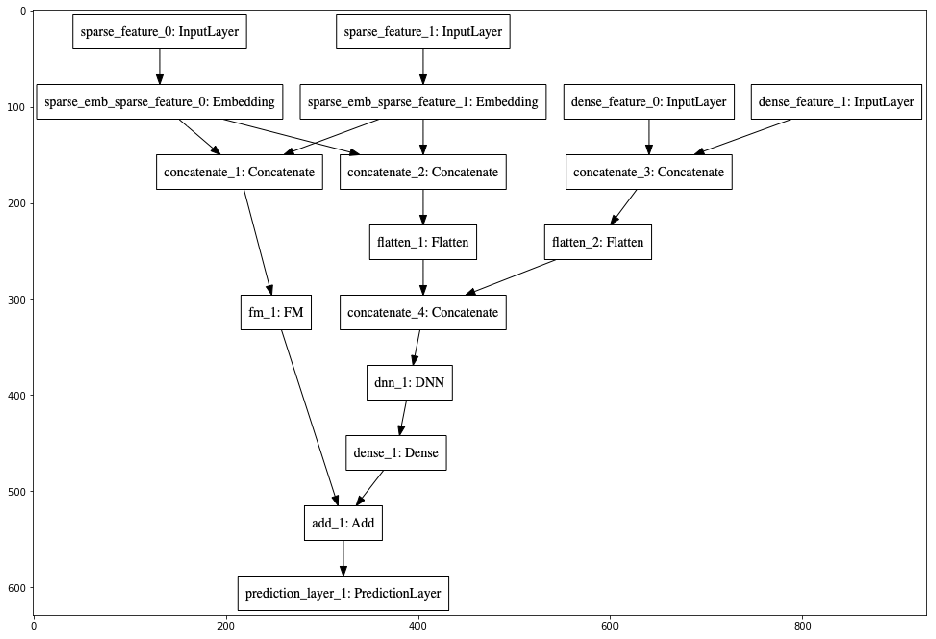

In [13]:
# DeepFM.DeepFM_test(2, 2) 读取生成的网络结构图片
plt.figure(figsize=(16, 16))
I = mpimg.imread('models/DeepFM_2019-12-22 19:29:28.png')
plt.imshow(I)
plt.show()

remain unknown feature:  ['contact', 'poutcome']
after feature engineering: (42808, 54)
original data:  (42808, 53) (42808,)
after over_sampler:  (75806, 53) (75806,)
Fold : 0
AUC score at 0 floder: 0.622585
Fold : 1
AUC score at 1 floder: 0.885867
Fold : 2
AUC score at 2 floder: 0.685724
Fold : 3
AUC score at 3 floder: 0.551703
Fold : 4
AUC score at 4 floder: 0.425754
5-floder total mean_score: 0.634326677985031
5-floder oof auc score: 0.6023143665751503
----train DeepFM finish!----


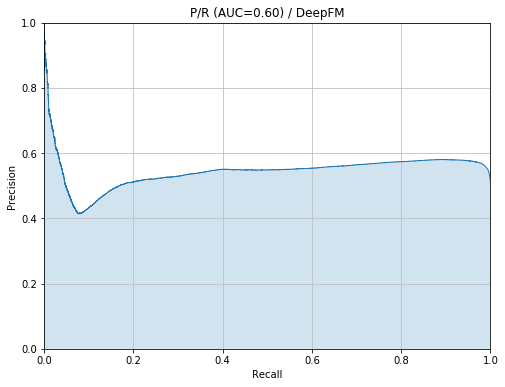


>>>在测试集上的表现： 0.6217185974724956

>>>混淆矩阵
 [[13639 24264]
 [ 4412 33491]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.76      0.36      0.49     37903
           1       0.58      0.88      0.70     37903

    accuracy                           0.62     75806
   macro avg       0.67      0.62      0.59     75806
weighted avg       0.67      0.62      0.59     75806



In [22]:
deepfm_oof = train_DeepFM()

### Wide and Deep Netual Network

In [23]:
def train_WDL():
    X, y, sparse_list, dense_list = feature_engineering.get_NN_data(use_over_sampler=True)

    data = pd.DataFrame(y)
    dnn_feature_columns = linear_feature_columns = sparse_list + dense_list
    feature_names = inputs.get_feature_names(linear_feature_columns + dnn_feature_columns)

    # kFold cv
    models = []
    scores = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        X_train = {name: X_train[name] for name in feature_names}
        X_val = {name: X_val[name] for name in feature_names}

        model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 64), task='binary',
                    dnn_dropout=0.5)

        best_param_path = './workspace/WideDeep/best_param_WideDeep.py_%d.h5' % i

        if os.path.exists(best_param_path):
            model.load_weights(best_param_path)
        else:
            model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'])
            es = EarlyStopping(monitor='val_binary_crossentropy', mode='min', patience=15)
            mc = ModelCheckpoint(best_param_path, monitor='val_binary_crossentropy', mode='min', save_best_only=True,
                                 verbose=False, save_weights_only=True)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=1024, epochs=1000, verbose=2,
                      callbacks=[es, mc])
            model.load_weights(best_param_path)

        y_pred = model.predict(X_val, batch_size=64).flatten()
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        models.append(model)
        data.loc[vdx, 'y_pred'] = y_pred

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % 'WideDeep')
    cal_roc_curve(data['y'], data['y_pred'], 'WideDeep')
    
    return data['y_pred']

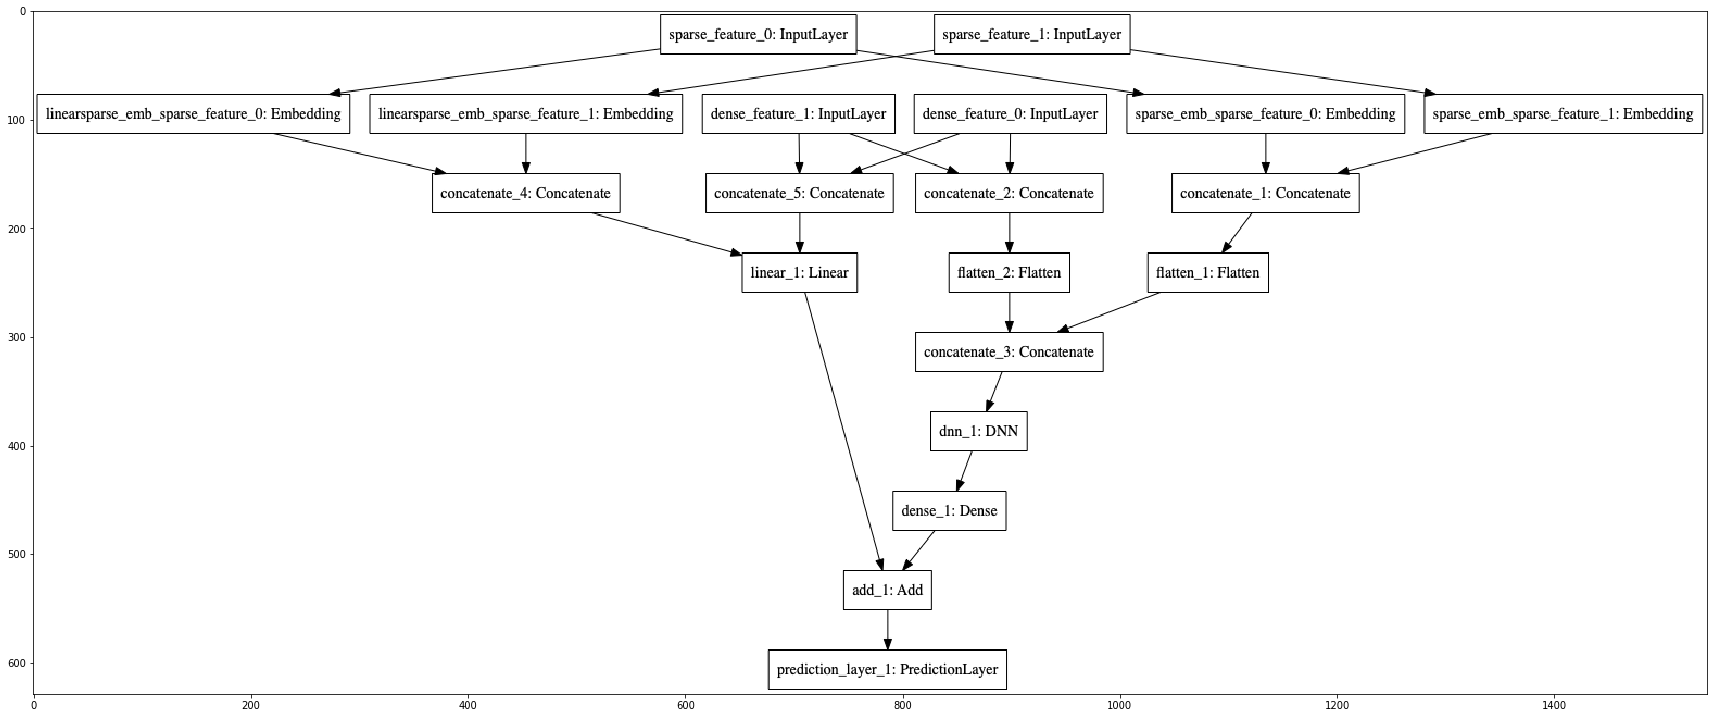

In [17]:
# WideDeep.WDL_test(2, 2) 读取生成的网络结构图片
plt.figure(figsize=(30, 30))
I = mpimg.imread('models/WDL_2019-12-21 19:21:01.png')
plt.imshow(I)
plt.show()

remain unknown feature:  ['contact', 'poutcome']
after feature engineering: (42808, 54)
original data:  (42808, 53) (42808,)
after over_sampler:  (75806, 53) (75806,)
Fold : 0
AUC score at 0 floder: 0.957902
Fold : 1
AUC score at 1 floder: 0.746030
Fold : 2
AUC score at 2 floder: 0.871518
Fold : 3
AUC score at 3 floder: 0.697444
Fold : 4
AUC score at 4 floder: 0.520382
5-floder total mean_score: 0.7586549074667981
5-floder oof auc score: 0.7579898171787061
----train WideDeep finish!----


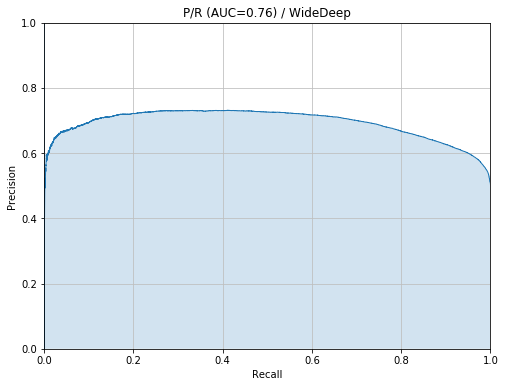


>>>在测试集上的表现： 0.7034139777853996

>>>混淆矩阵
 [[25411 12492]
 [ 9991 27912]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.72      0.67      0.69     37903
           1       0.69      0.74      0.71     37903

    accuracy                           0.70     75806
   macro avg       0.70      0.70      0.70     75806
weighted avg       0.70      0.70      0.70     75806



In [24]:
WDL_oof = train_WDL()

# Model Ensemble

### Stacking

In [42]:
def model_stacking():
    X, y = feature_engineering.get_train_data(use_over_sampler=True)
    data = pd.DataFrame(y)

    #lgbm = LightGBM.train_lgbm(plot=False)
    #cat = CatBoost.train_cat(plot=False)
    print(fnn_oof.shape)
    print(pnn_oof.shape)

    #deepFM = DeepFM.train_DeepFM()
    #print(deepFM.shape)

    X = pd.concat([lgbm_oof, pnn_oof, fnn_oof], axis=1)
    print(X.shape)

    models = []
    scores = []
    checkpoint_predictions = []

    kf = StratifiedKFold(n_splits=5, random_state=42)
    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_val, y_train, y_val = X.loc[tdx], X.loc[vdx], y.loc[tdx], y.loc[vdx]
        y_true = y_val

        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_true, y_pred)
        print("AUC score at %d floder: %f" % (i, auc))
        scores.append(auc)
        data.loc[vdx, 'y_pred'] = y_pred
        # print(data['y_pred'].value_counts())

    mean_score = np.mean(scores)
    oof = roc_auc_score(data['y'], data['y_pred'])
    print("5-floder total mean_score:", mean_score)
    print("5-floder oof auc score:", oof)
    print("----train %s finish!----" % 'Stacking')
    cal_roc_curve(data['y'], data['y_pred'], 'Stacking')
    
    return data['y_pred']

original data:  (42808, 64) (42808,)
after over_sampler:  (75806, 64) (75806,)
(75806,)
(75806,)
(75806, 3)
Fold : 0
AUC score at 0 floder: 0.969374
Fold : 1
AUC score at 1 floder: 0.991041
Fold : 2
AUC score at 2 floder: 0.990609
Fold : 3
AUC score at 3 floder: 0.984831
Fold : 4
AUC score at 4 floder: 0.952909
5-floder total mean_score: 0.9777526171307184
5-floder oof auc score: 0.9430329312829413
----train Stacking finish!----


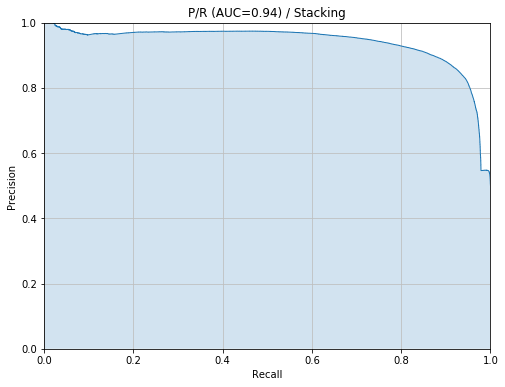


>>>在测试集上的表现： 0.887396775980793

>>>混淆矩阵
 [[34100  3803]
 [ 4733 33170]]

>>>分类评价函数
               precision    recall  f1-score   support

           0       0.88      0.90      0.89     37903
           1       0.90      0.88      0.89     37903

    accuracy                           0.89     75806
   macro avg       0.89      0.89      0.89     75806
weighted avg       0.89      0.89      0.89     75806



In [43]:
stakcing_oof = model_stacking()

# Plot final result

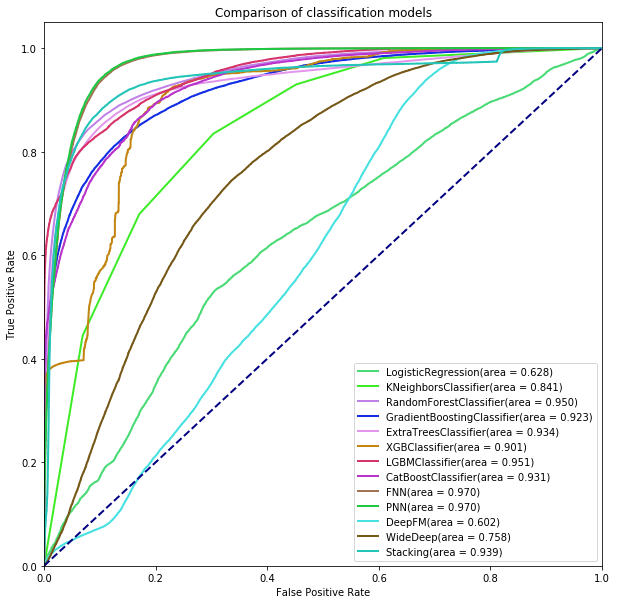

In [27]:
plot_roc_curve()

In [36]:
def plot_model_result():
    train = pd.DataFrame()
    train['model'] = model
    train['accuracy_score'] = accuracy_score
    train['recall_score'] = recall_score
    train['precision_score'] = precision_score
    train['f1_score'] = f1_score
    train['ROC_AUC_Score'] = ROC_AUC_Score
    return train

In [37]:
plot_model_result()

,model,accuracy_score,recall_score,precision_score,f1_score,ROC_AUC_Score
0,LogisticRegression,0.608131,0.599953,0.609929,0.604900,0.627944
1,KNeighborsClassifier,0.765625,0.834657,0.733401,0.780760,0.841279
2,RandomForestClassifier,0.850935,0.928766,0.803666,0.861699,0.949868
3,GradientBoostingClassifier,0.826280,0.893386,0.787672,0.837205,0.923399
4,ExtraTreesClassifier,0.818669,0.934596,0.758690,0.837506,0.933598
5,XGBClassifier,0.846965,0.922407,0.801476,0.857700,0.900553
6,LGBMClassifier,0.849418,0.917051,0.807785,0.858957,0.950512
7,CatBoostClassifier,0.838891,0.916682,0.793265,0.850520,0.930610
8,FNN,0.917210,0.947972,0.893028,0.919681,0.969636
9,PNN,0.919584,0.950268,0.895324,0.921978,0.970371
